In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-dataset/hindi_preprocessed_2.csv
/kaggle/input/mr-dataset/marathi_preprocessed_2.csv


In [22]:
from tqdm import tqdm

In [23]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

In [24]:
import torch

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))


else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [25]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

In [26]:
class IndicBertClassfier(torch.nn.Module):
    def __init__(self,bert_model,bert_config,num_class):
        super(IndicBertClassfier,self).__init__()
        
        self.bert_model=bert_model
        self.dropout=torch.nn.Dropout(0.1)
        self.fc1=torch.nn.Linear(bert_config["hidden_size"],bert_config["hidden_size"])
        self.fc2=torch.nn.Linear(bert_config["hidden_size"],num_class)
    def forward(self, token_ids, attention_mask=None):
        bert_out = self.bert_model(input_ids=token_ids, attention_mask=attention_mask)[1]  # Sentence vector [batch_size, hidden_size]
        bert_out=self.dropout(bert_out)
        bert_out=self.fc1(bert_out) 
        bert_out=self.dropout(bert_out)
        bert_out=self.fc2(bert_out) #[batch_size,num_class]
        return bert_out

In [27]:
config = {
  "model_type": "albert",
  "attention_probs_dropout_prob": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "embedding_size": 128,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_hidden_groups": 1,
  "net_structure_type": 0,
  "gap_size": 0,
  "num_memory_blocks": 0,
  "inner_group_num": 1,
  "down_scale_factor": 1,
  "type_vocab_size": 2,
  "vocab_size": 200000
}

In [28]:
import pandas as pd
test_data = pd.read_csv("/kaggle/input/hindi-dataset/hindi_preprocessed_2.csv")
test_data.rename(columns = {'text':'sentence', 'task_1':'label'}, inplace = True)

print('Number of training sentences: {:,}\n'.format(test_data.shape[0]))
test_data.dropna()
test_data.sample(10)

Number of training sentences: 4,594



,sentence,label
2755,अपने ही सांसद को बचा न सका पूरी बिहार संभालने ...,0
3328,ज्यादातर राज्यो के पास yrs के लोगो के vaccinat...,1
2569,विज्ञापन में वैक्सीन लगवाने की अपील लेकिन वैक्...,1
174,भाई मीठी छुरी बनके आज मोदीजी ने विपक्ष को छलनी...,1
644,नेहरू जी को साल बाद भी जिम्मेवार ठहराने वाला ...,1
1565,देश का िस्टम आत्मनिर्भर से विश्वनिर्भर हो गया,1
2065,जानें टीकाकरण से जुड़ी जानकारी दिल्ली के किन ज...,1
1231,बिजली कर्मचारियों का मजाक बनाया जा रहा है जबकि...,1
3426,दोगले कभी ना कभी अपना दोगला पन दिखा ही जाता है,0
3130,“हम अंधेरों का साथ दे बैठे अब चिताओं से मुल्क ...,1


In [29]:
def get_test_data(train_data,max_length=128):
    data=[]
    labels = []
    
    comments = list(train_data["sentence"])
    tags = list(train_data["label"])
    for i in range(len(comments)):
        #row = tokenize(train_data["commentText"][i])
        row = comments[i]
        ids=tokenizer.encode(row.strip(),max_length=max_length,padding='max_length',truncation=True)
        data.append(ids)
        labels.append(tags[i])    
    
    return (data,labels)

In [30]:
from torch.utils import data
class DataGen(data.Dataset):
    def __init__(self,data,label):
        self.data=data
        self.label=label
    def __len__(self):
        return len(self.data)
            
    def __getitem__(self,index):
        return np.array(self.data[index]),np.array(self.label[index])

In [31]:
test_x,test_labels = get_test_data(test_data)

In [32]:
IndicBertClassfier = IndicBertClassfier(model,config,2)

In [33]:
device=torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
IndicBertClassfier = IndicBertClassfier.to(device)

In [34]:
# model_eval = IndicBertClassfier

In [35]:
test_datase=DataGen(test_x,test_labels)
test_dataload=data.DataLoader(test_datase,batch_size=32)

In [36]:
preds = []

for steps,(token_ids,label) in tqdm(enumerate(test_dataload)):
    
    #print(steps)
    with torch.no_grad():
        token_ids = token_ids.to(device)
        attention_mask = (token_ids != 0).float()  # Create attention mask
        out = IndicBertClassfier(token_ids, attention_mask=attention_mask)
        res = list(out.argmax(1))
        for r in res:
            preds.append(r.tolist())

144it [00:29,  4.93it/s]


In [37]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.31      0.27      0.29      1433
           1       0.69      0.72      0.70      3161

    accuracy                           0.58      4594
   macro avg       0.50      0.50      0.49      4594
weighted avg       0.57      0.58      0.57      4594



In [38]:
from sklearn.metrics import f1_score

# Compute F1 score
f1 = f1_score(test_labels, preds, average='macro')

print("F1 Score:", f1)

F1 Score: 0.4947286959534621


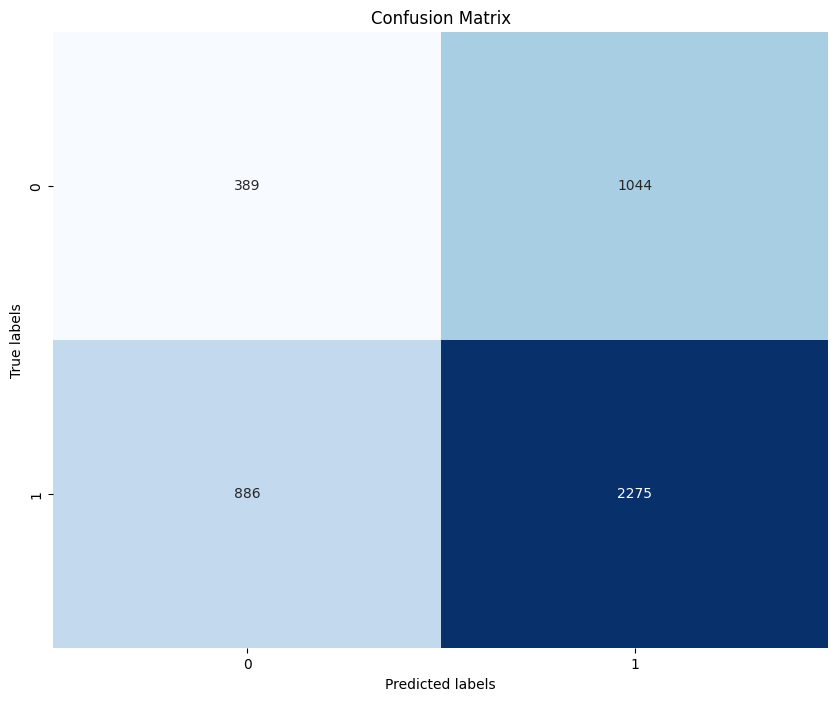

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `test_labels` and `preds` are your true labels and predicted labels, respectively

# Compute confusion matrix
cm = confusion_matrix(test_labels, preds)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
